
# aSPEM Experiment : analysis

https://scikit-learn.org/stable/auto_examples/neighbors/plot_nearest_centroid.html#sphx-glr-auto-examples-neighbors-plot-nearest-centroid-py




TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%load_ext autoreload
%autoreload 2
#from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

from aSPEM import aSPEM
import bayesianchangepoint as bcp

%matplotlib inline

In [2]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [3]:
list_sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']

nb_sujet = len(list_sujet)
COLOR = ['b', 'r', 'k', 'g', 'm', 'c',
         'darkblue', 'darkred', 'peru', 'darkgreen', 'darkmagenta', 'darkcyan'] #[(0+(1/nb_sujet)*n, 0, 0, 0.5) for n in range(nb_sujet)]

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

In [5]:
fig_width = 15
t_titre = 70
t_label = (30*4)/3

## Data Scalling

In [6]:
data_scalling = e.Data_Scalling()
new_bet, new_va = data_scalling['new_bet_full'], data_scalling['new_va_full']

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Find h

In [7]:
h_bet, h_va = e.Find_h(new_bet, new_va, modes_bcp='mean')

AM BMC CS DC FM IP LB OP RS SR TN YK 

In [8]:
def scatter_mean(h_bet, h_va, maxx=0.55, maxy=0.25, minx=0, miny=0, ex=0.02, ey=0.01, log=True, cent=False, 
                 triangle=True, color=False, mean='mean', fig_width=10) :
    
    if triangle is True : from matplotlib.patches import Polygon
    fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)), constrained_layout=True) #/(1.6180*1))
    
    if type(h_bet)==dict :
        list_bet, list_va, l_100_bet, l_100_va = [], [], [], []
        for s in list_sujet :
            list_bet.append(h_bet['block'][s]) ; list_va.append(h_va['block'][s])
            l_100_bet.append(h_bet['100'][s]) ; l_100_va.append(h_va['100'][s])
        bet, va = list_bet, list_va
    
    m_bet, m_va = [], []
    for x in range(len(bet)):
        if color is False : c = 'k'
        else :              c = color[x]
        
        if cent is True : axs.scatter(l_100_bet[x], l_100_va[x], color=c,  s=25, alpha=0.9)
        
        if triangle is True :
            c_b = ['k', 'grey', 'r']
            #for b in range(3) : axs.scatter(bet[x][b], va[x][b], c=c, s=50)
            baba = np.array([[bet[x][y], va[x][y]] for y in range(len(va[x]))])
            poly = Polygon(baba, color=c, alpha=0.2, lw=2)
            axs.add_artist(poly)
            
        if mean=='mean' :      mean_bet, mean_va = np.mean(bet[x]),   np.mean(va[x])
        elif mean=='mediane' : mean_bet, mean_va = np.median(bet[x]), np.median(va[x])           
        
        #if log is False :
        #    if triangle is True :
        #        #axs.scatter(mean_bet, mean_va, color=c,  s=50, alpha=0.9)
        #        axs.text(mean_bet, mean_va, list_sujet[x], fontsize=12, va='center', ha='center')
            
        m_bet.append(mean_bet)
        m_va.append(mean_va)

    axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')
    axs.vlines(0.025, -ey, 0.025, colors='k') ; axs.hlines(0.025, -ex, 0.025, colors='k')

    if log: axs.set_xscale('log') ; axs.set_yscale('log')
    axs.set_xlabel('h$_{bet}$', fontsize=t_label) ; axs.set_ylabel('h$_{v_a}$', fontsize=t_label)
    axs.tick_params(axis='both', labelsize=t_label/1.8)
    axs.axis([minx-ex ,maxx+ex,miny-ey,maxy+ey])
    fig.tight_layout()
    
    return fig, axs

In [9]:
COLOR = ['crimson', 'saddlebrown', 'k', 'darkseagreen', 'dimgrey', 'teal',
         'slateblue', 'firebrick', 'peru', 'darkolivegreen', 'goldenrod', 'darkcyan']

Moyenne par Sujet block log


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


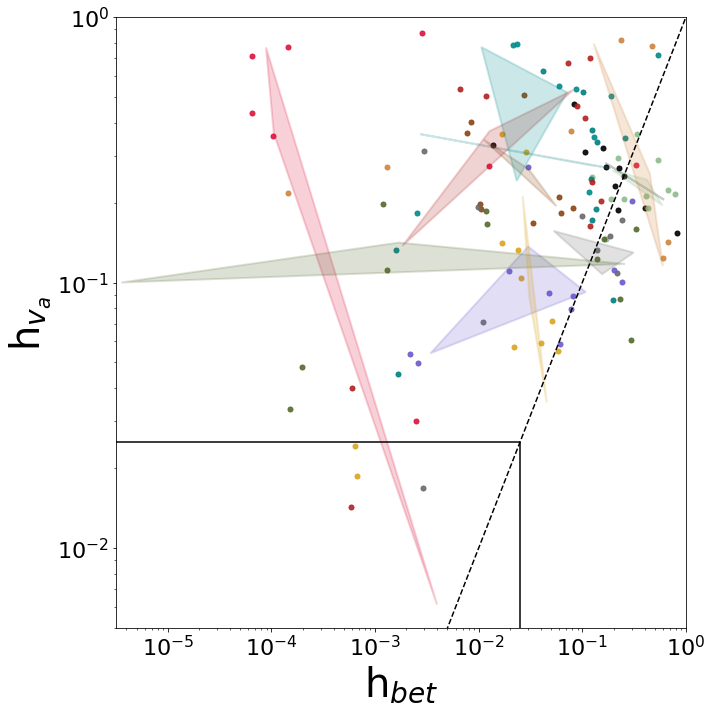

In [10]:
print('Moyenne par Sujet block log')

fig, ax = scatter_mean(h_bet, h_va, maxx=10**0, maxy=10**0, minx=10**-5.5, miny=10**-2.3, ex=0, ey=0, color=COLOR, cent=True)
#for ext in exts: fig.savefig(f'{msfigpath}/5_inter-individual_differences_fit' + ext, dpi=dpi)

## Calcule MI

In [11]:
Full = e.Full_list()

In [12]:
def mutual_information(hgram):
    """ Mutual information for joint histogram
    https://matthew-brett.github.io/teaching/mutual_information.html"""
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def mumu(p, data) :
    hist, x_edges, y_edges = np.histogram2d(p, data ,bins=20)
    return mutual_information(hist)

In [13]:
def find_mumu(h_bet, h_va) :
    HBET, HVA = [], []
    for suj in list_sujet :
        HBET.extend(h_bet['block'][suj])
        HVA.extend(h_va['block'][suj])
    
    print('h_bet : mean=%s, std=%s'%(np.nanmean(HBET), np.nanstd(HBET)))
    print('h_va : mean=%s, std=%s'%(np.nanmean(HVA), np.nanstd(HVA)))
    
    mu_bet,mu_va = [], []
    for suj in list_sujet :
        for b in range(3) :
            result = Full[Full.sujet==suj]['results'][200*b:200*(b+1)]
            va = Full[Full.sujet==suj]['va'][200*b:200*(b+1)]

            bino = Full[Full.sujet==suj]['bino'][200*b:200*(b+1)]

            p_hat_bet, p_hat_va = [], []
            liste = [0,50,100,150,200]
            for s in range(len(liste)-1) :

                p_bar, r_bar, beliefs = bcp.inference(np.asarray(bino[liste[s]:liste[s+1]]), h=h_bet['block'][suj][b], p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='mean')
                p_hat_bet.extend(p_hat)

                p_bar, r_bar, beliefs = bcp.inference(np.asarray(bino[liste[s]:liste[s+1]]), h=h_va['block'][suj][b], p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='mean')
                p_hat_va.extend(p_hat)

            mu_bet.append(mumu(p_hat_bet, result))

            proba = np.ma.masked_array(p_hat_va, mask=np.isnan(va.tolist())).compressed()
            data = np.ma.masked_array(va.tolist(), mask=np.isnan(va.tolist())).compressed()

            mu_va.append(mumu(proba, data))
    
    print('mumu h_bet : mean=%s, std=%s'%(np.nanmean(mu_bet), np.nanstd(mu_bet)))
    print('mumu h_va : mean=%s, std=%s'%(np.nanmean(mu_va), np.nanstd(mu_va)))

In [14]:
find_mumu(h_bet, h_va)

h_bet : mean=0.1387997664369719, std=0.18012915544859032
h_va : mean=0.2619282403949119, std=0.1957761085243669
mumu h_bet : mean=1.0255601237296388, std=0.3418048976669125
mumu h_va : mean=0.7426902388779366, std=0.20955591546288668


# Classifier

In [15]:
COLOR = ['crimson', 'saddlebrown', 'grey', 'darkseagreen', 'dimgrey', 'r',
         'slateblue', 'w', 'peru', 'darkolivegreen', 'goldenrod', 'c']

from matplotlib.colors import ListedColormap
cmap = ListedColormap(COLOR)

In [16]:
def fing_X(h_bet, h_va, log=False) :
    X, y = [[],[]], []
    for s, suj in enumerate(list_sujet) :
        for b in range(len(h_bet[suj])) :
            y.append(s)
            if log is True : X[0].append(np.log10(h_bet[suj][b])) ; X[1].append(np.log10(h_va[suj][b]))
            else :           X[0].append(h_bet[suj][b]) ;           X[1].append(h_va[suj][b])
                   
    X = np.array(X) ; X = X.transpose()
    y = np.array(y)
    return X, y

In [17]:
def Classifier(X, y) :

    r_s = 0
    
    dim_red = [('None', X)]
    
    from sklearn import preprocessing as pre
    dim_red.append(('StandardScaler',   pre.StandardScaler()))
    dim_red.append(('Quantile_normal',  pre.QuantileTransformer(output_distribution='normal', n_quantiles=int(132/5))))
    dim_red.append(('Quantile_uniform', pre.QuantileTransformer(output_distribution='uniform', n_quantiles=int(132/5))))
    dim_red.append(('RobustScaler',     pre.RobustScaler(quantile_range=(25, 75))))
    dim_red.append(('PowerTransformer', pre.PowerTransformer(method='yeo-johnson')))

    
    CLF = []
    
    from sklearn import ensemble
    CLF.append(('AdaBoost',         ensemble.AdaBoostClassifier(random_state=r_s)))
    CLF.append(('Bagging',          ensemble.BaggingClassifier(random_state=r_s)))
    CLF.append(('ExtraTrees',       ensemble.ExtraTreesClassifier(random_state=r_s)))
    CLF.append(('GradientBoosting', ensemble.GradientBoostingClassifier(random_state=r_s)))
    CLF.append(('RandomForest',     ensemble.RandomForestClassifier(random_state=r_s)))

    from sklearn.gaussian_process import GaussianProcessClassifier
    CLF.append(('GaussianProcess', GaussianProcessClassifier(random_state=r_s)))
    
    from sklearn import linear_model
    CLF.append(('LogisticRegression',   linear_model.LogisticRegression(random_state=r_s)))
    CLF.append(('LogisticRegressionCV', linear_model.LogisticRegressionCV(random_state=r_s)))
    CLF.append(('PassiveAggressive',    linear_model.PassiveAggressiveClassifier(random_state=r_s)))
    CLF.append(('Ridge',                linear_model.RidgeClassifier(random_state=r_s)))
    CLF.append(('RidgeCV',              linear_model.RidgeClassifierCV()))
    CLF.append(('SGD',                  linear_model.SGDClassifier(random_state=r_s)))
    
    from sklearn import naive_bayes
    CLF.append(('BernoulliNB', naive_bayes.BernoulliNB()))
    #CLF.append(('MultinomialNB', naive_bayes.MultinomialNB()))
    #CLF.append(('ComplementNB',  naive_bayes.ComplementNB()))

    from sklearn import neighbors
    CLF.append(('KNeighbors',      neighbors.KNeighborsClassifier()))
    CLF.append(('NearestCentroid', neighbors.NearestCentroid()))
    #CLF.append(('RadiusNeighborsClassifier', neighbors.RadiusNeighborsClassifier()))
    
    from sklearn import neural_network
    CLF.append(('MLPClassifier', neural_network.MLPClassifier(random_state=r_s)))
    
    from sklearn import semi_supervised
    CLF.append(('LabelPropagation', semi_supervised.LabelPropagation()))
    
    from sklearn import svm
    CLF.append(('LinearSVC', svm.LinearSVC(random_state=r_s)))
    CLF.append(('NuSVC',     svm.NuSVC(random_state=r_s)))
    CLF.append(('SVC',       svm.SVC(random_state=r_s)))
    
    from sklearn import tree
    CLF.append(('DecisionTree', tree.DecisionTreeClassifier()))
    CLF.append(('ExtraTree',    tree.ExtraTreeClassifier()))
    
    '''
    CLF.append(('LinearSVC',  svm.LinearSVC(C=1., max_iter=10000)))
    CLF.append(('SVC_linear', svm.SVC(kernel='linear', C=1.)))    
    CLF.append(('SVC_rbf',    svm.SVC(kernel='rbf', gamma=0.7, C=1.)))
    CLF.append(('SVC_poly',   svm.SVC(kernel='poly', degree=3, gamma='auto', C=1.)))
    '''
    
    for c, (NAME, clf) in enumerate(CLF) :
        fig, axs = plt.subplots(1, len(dim_red), figsize=(20,20/len(dim_red)))

        for i, (name, model) in enumerate(dim_red):
        
            try :
                if name=='None' :        X_t = X
                else : model.fit(X, y) ; X_t = model.transform(X)
                clf.fit(X_t, y)
                acc_knn = clf.score(X_t, y)

                y_pred = clf.predict(X_t)
                x_min, x_max = X_t[:, 0].min(), X_t[:, 0].max()
                y_min, y_max = X_t[:, 1].min(), X_t[:, 1].max()

                if name == 'NCA' : h=0.2
                else :             h=0.01
                xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/500),
                                     np.arange(y_min, y_max, (y_max-y_min)/500))
                Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)

                axs[i].pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.5)
                axs[i].scatter(X_t[:, 0], X_t[:, 1], c=y, s=50, edgecolors='k', cmap=cmap)
                axs[i].set_title("classifier : %s\nnormalisation : %s\nTest accuracy = %.2f"%(NAME, name, acc_knn))
            except : pass
        plt.show()

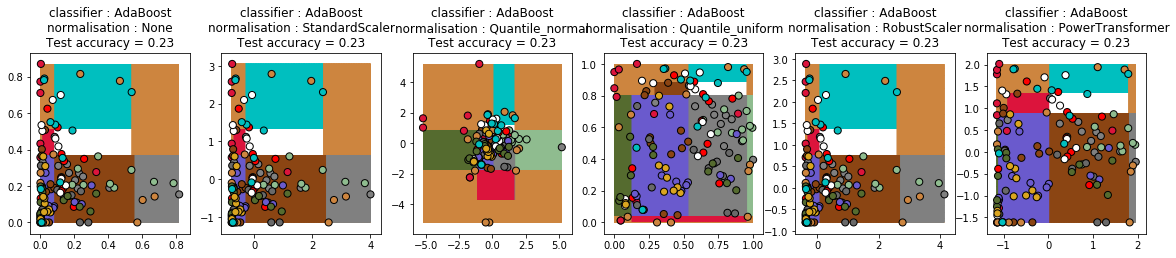

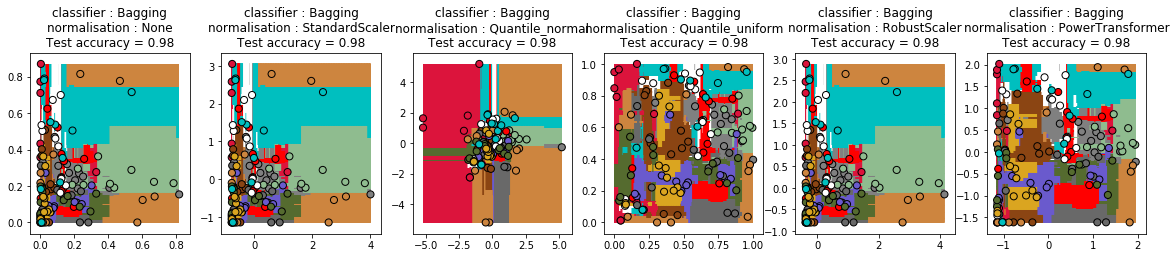

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


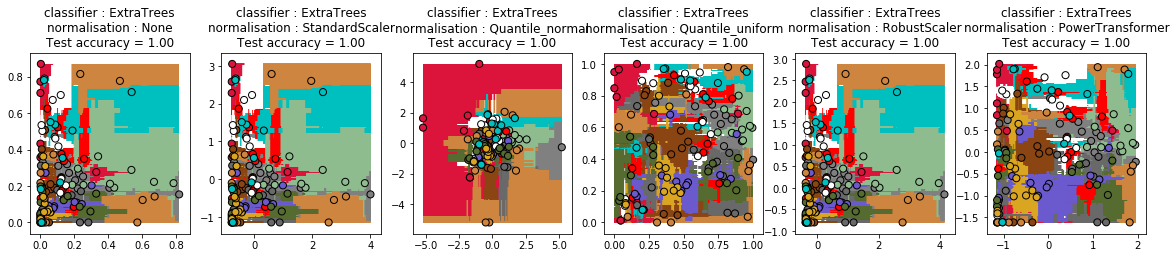

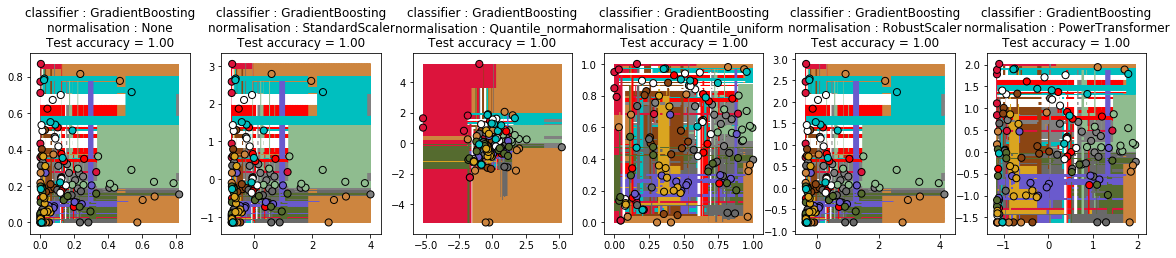

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


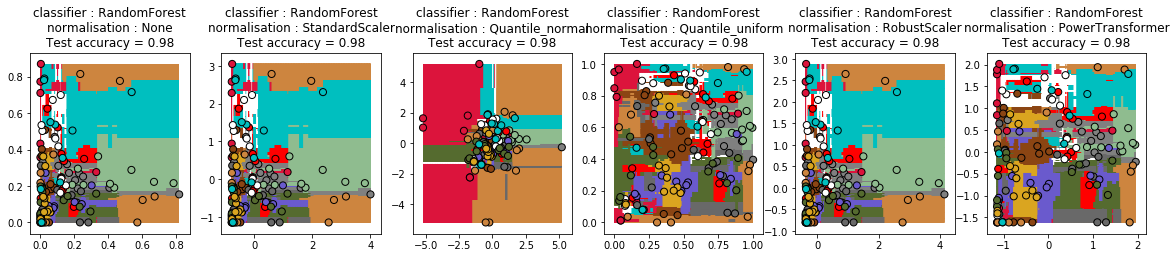

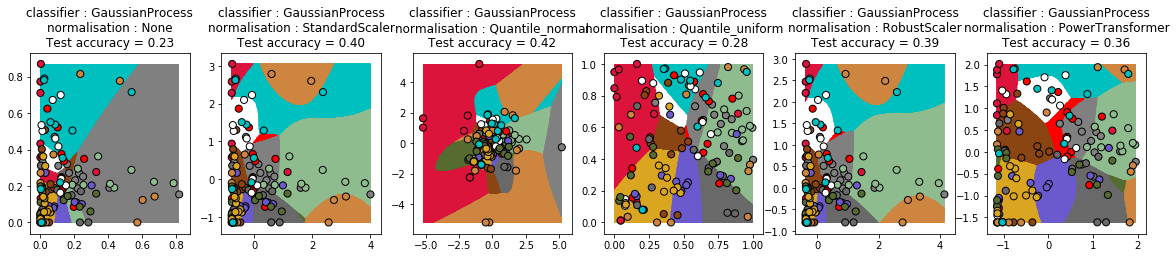

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

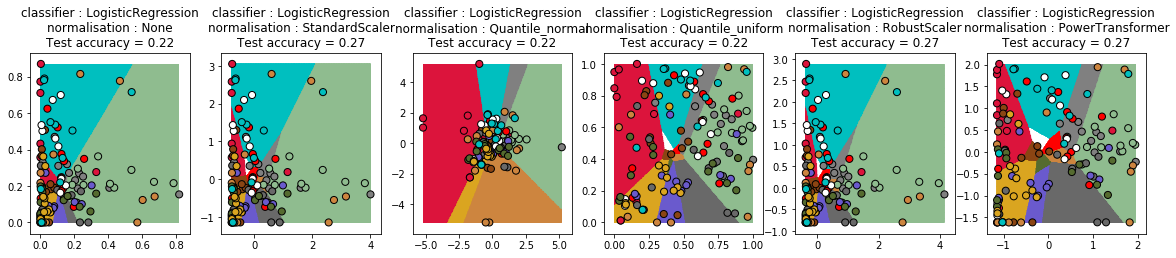

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.5/dis

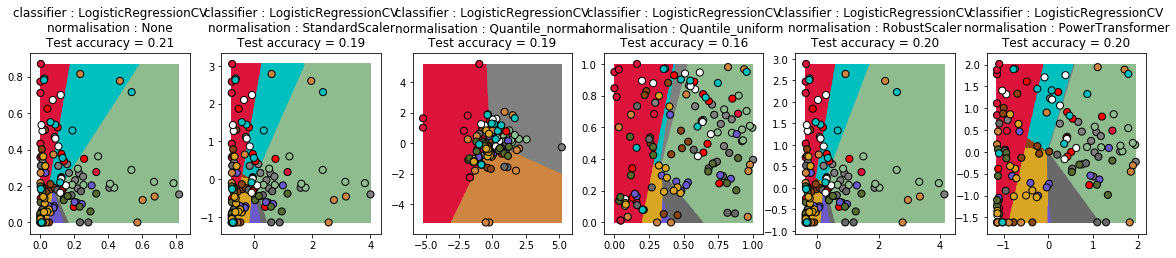

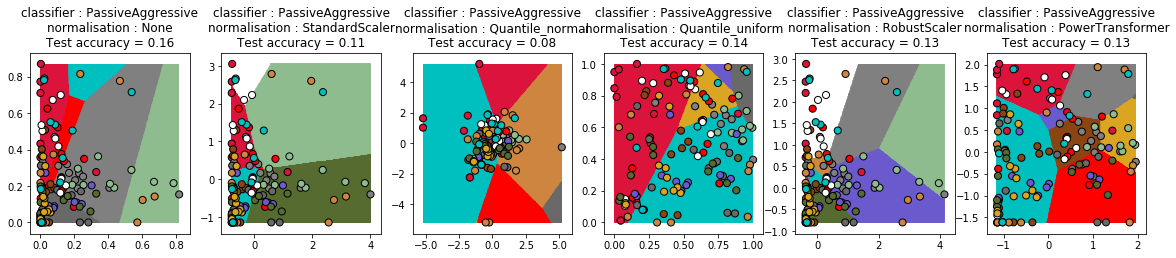

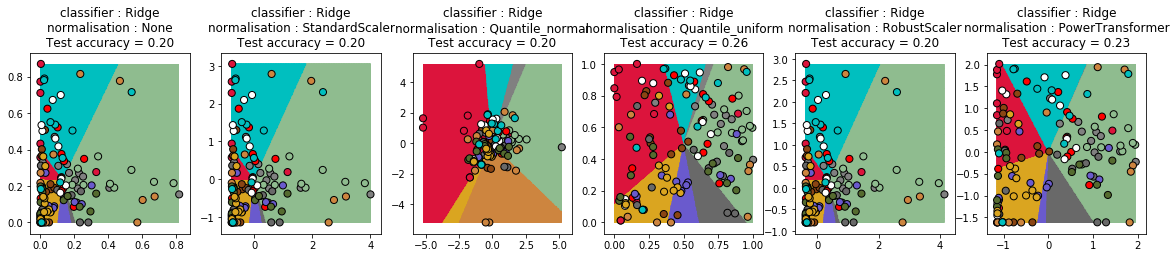

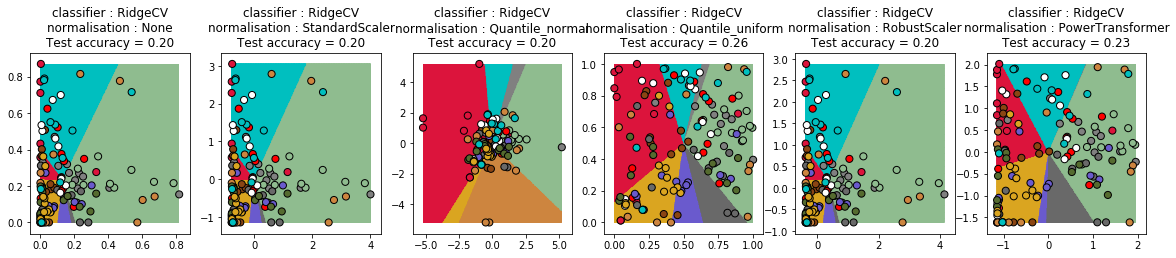

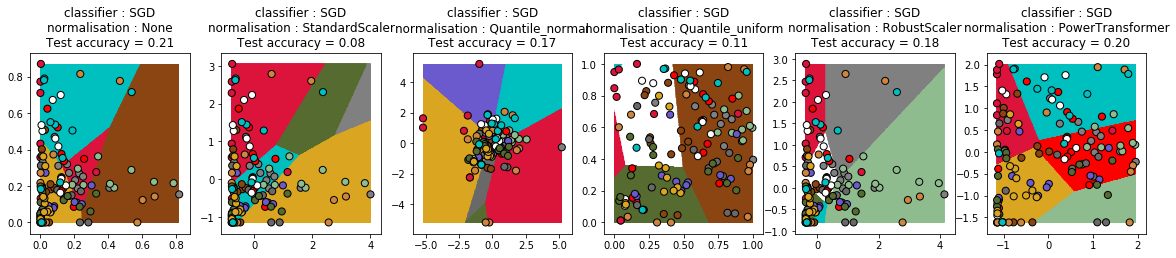

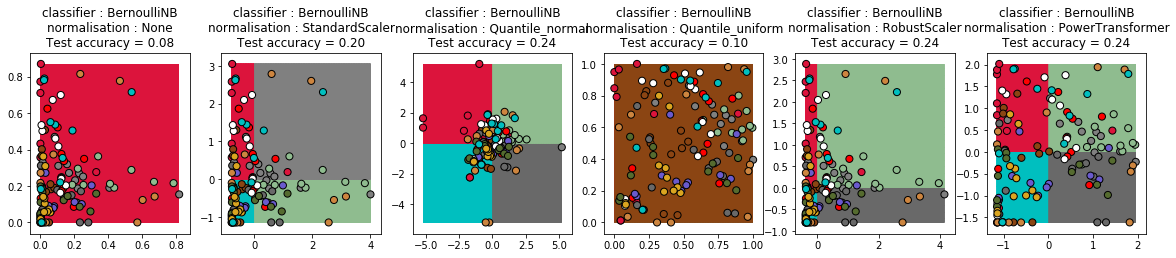

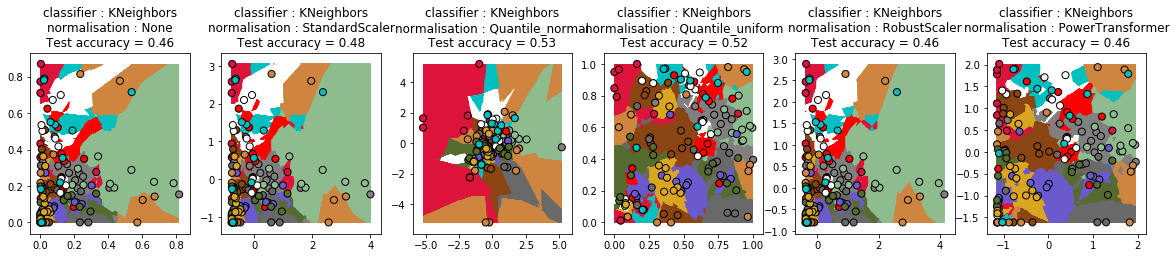

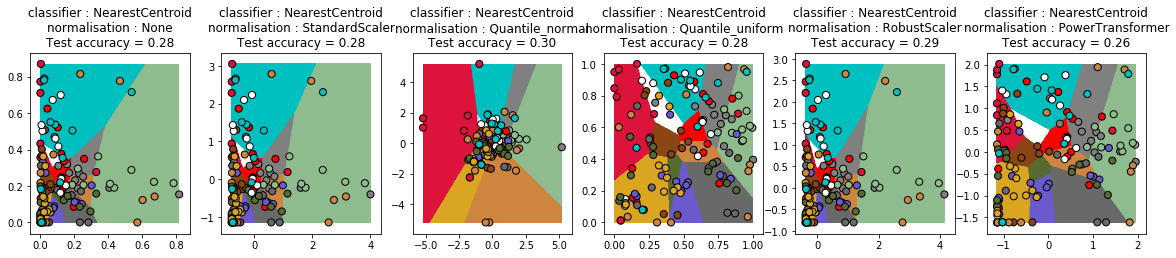

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

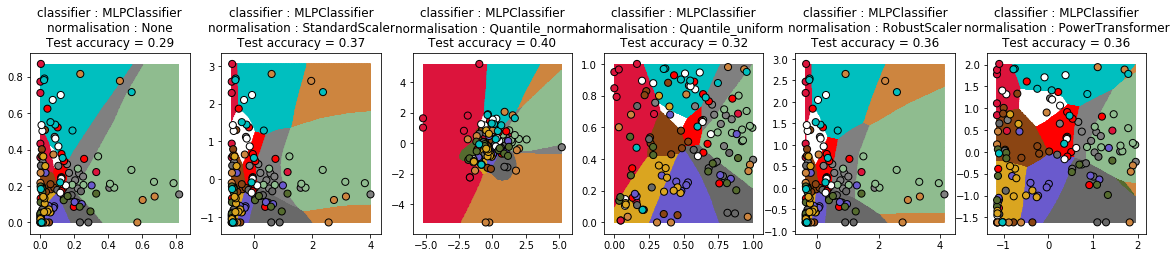

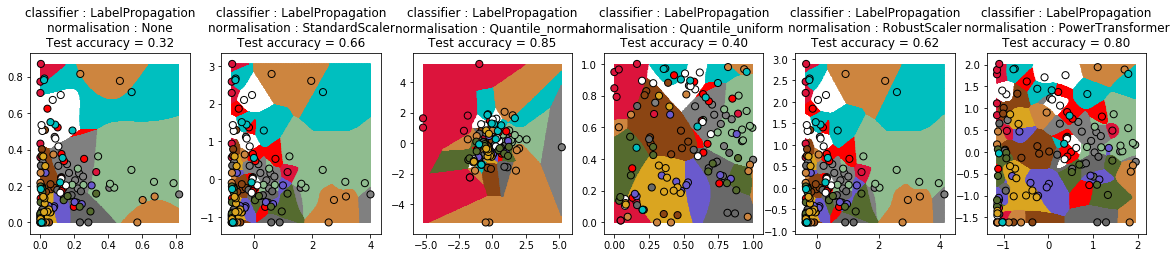

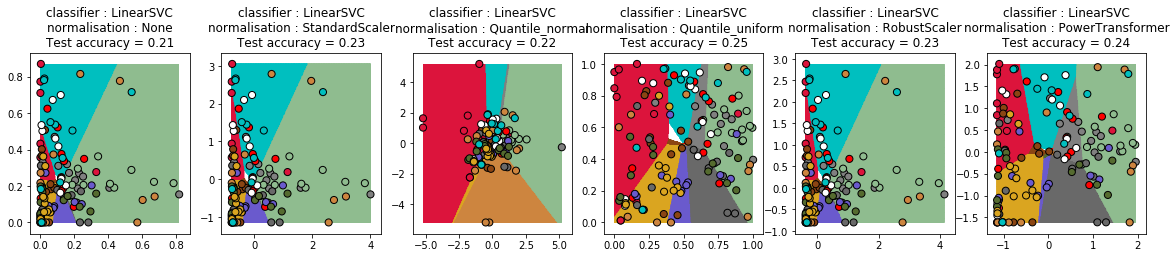

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

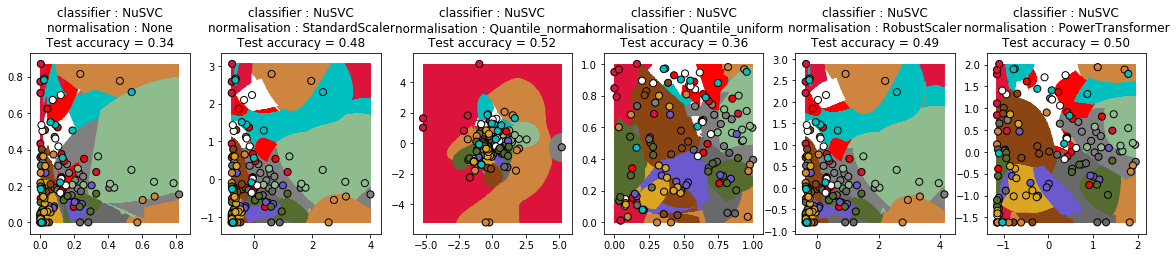

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

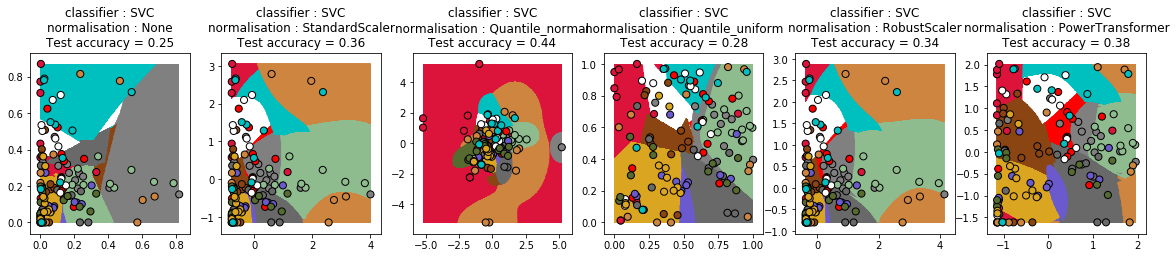

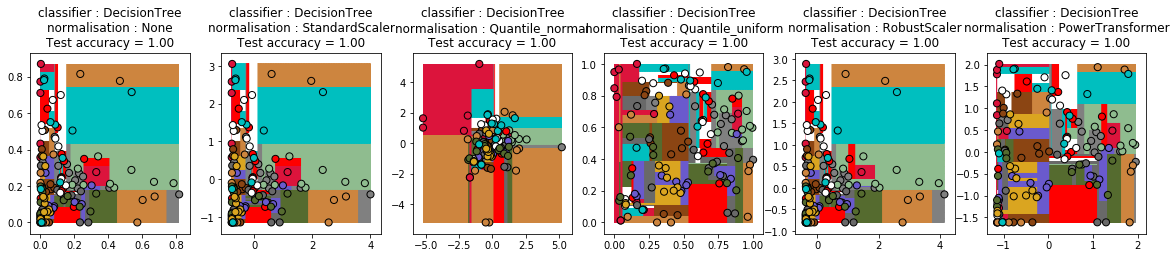

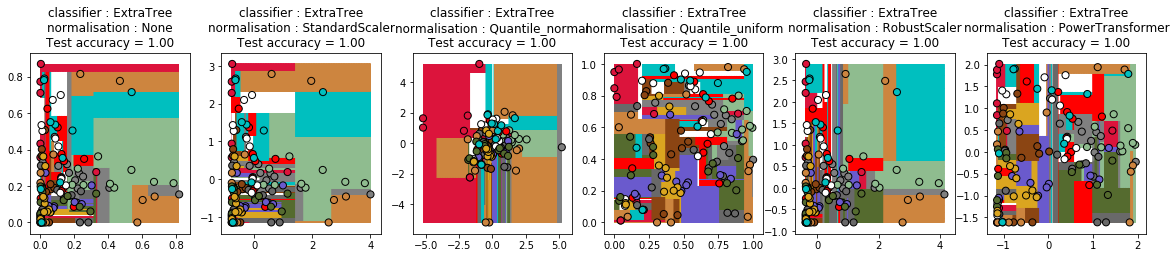

In [18]:
X, y = fing_X(h_bet['100'], h_va['100'], log=False)
Classifier(X, y)